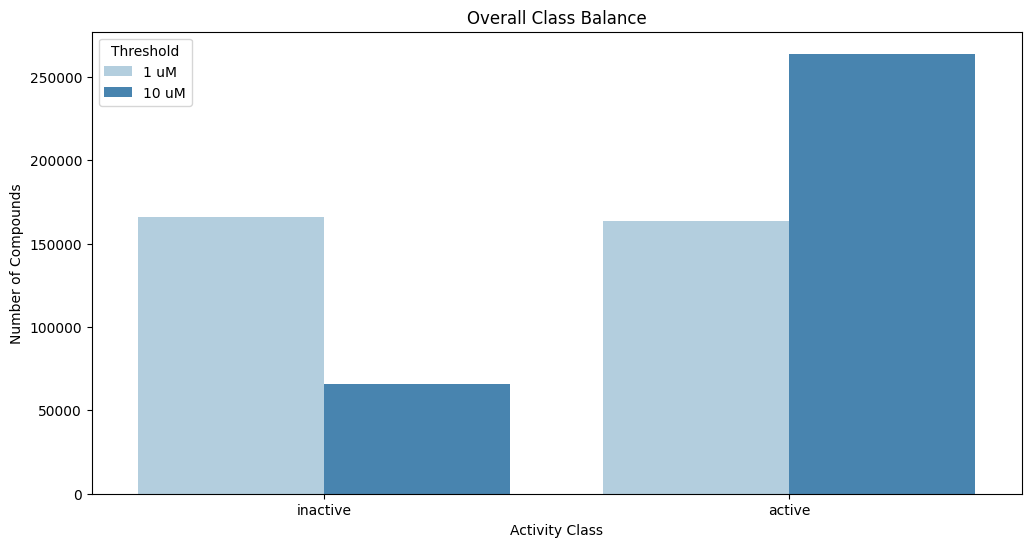

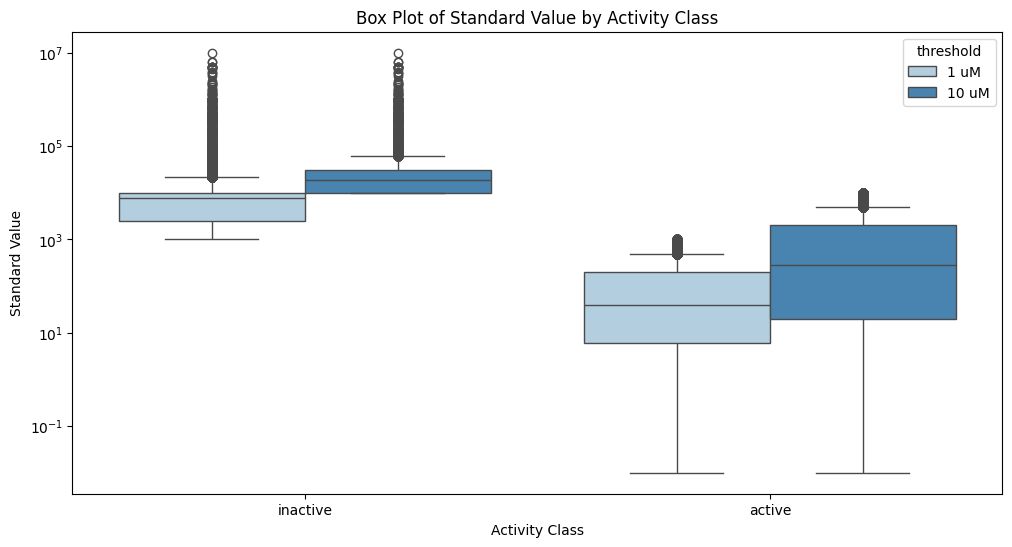

<ipython-input-25-fb75b3d500de>:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-25-fb75b3d500de>:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


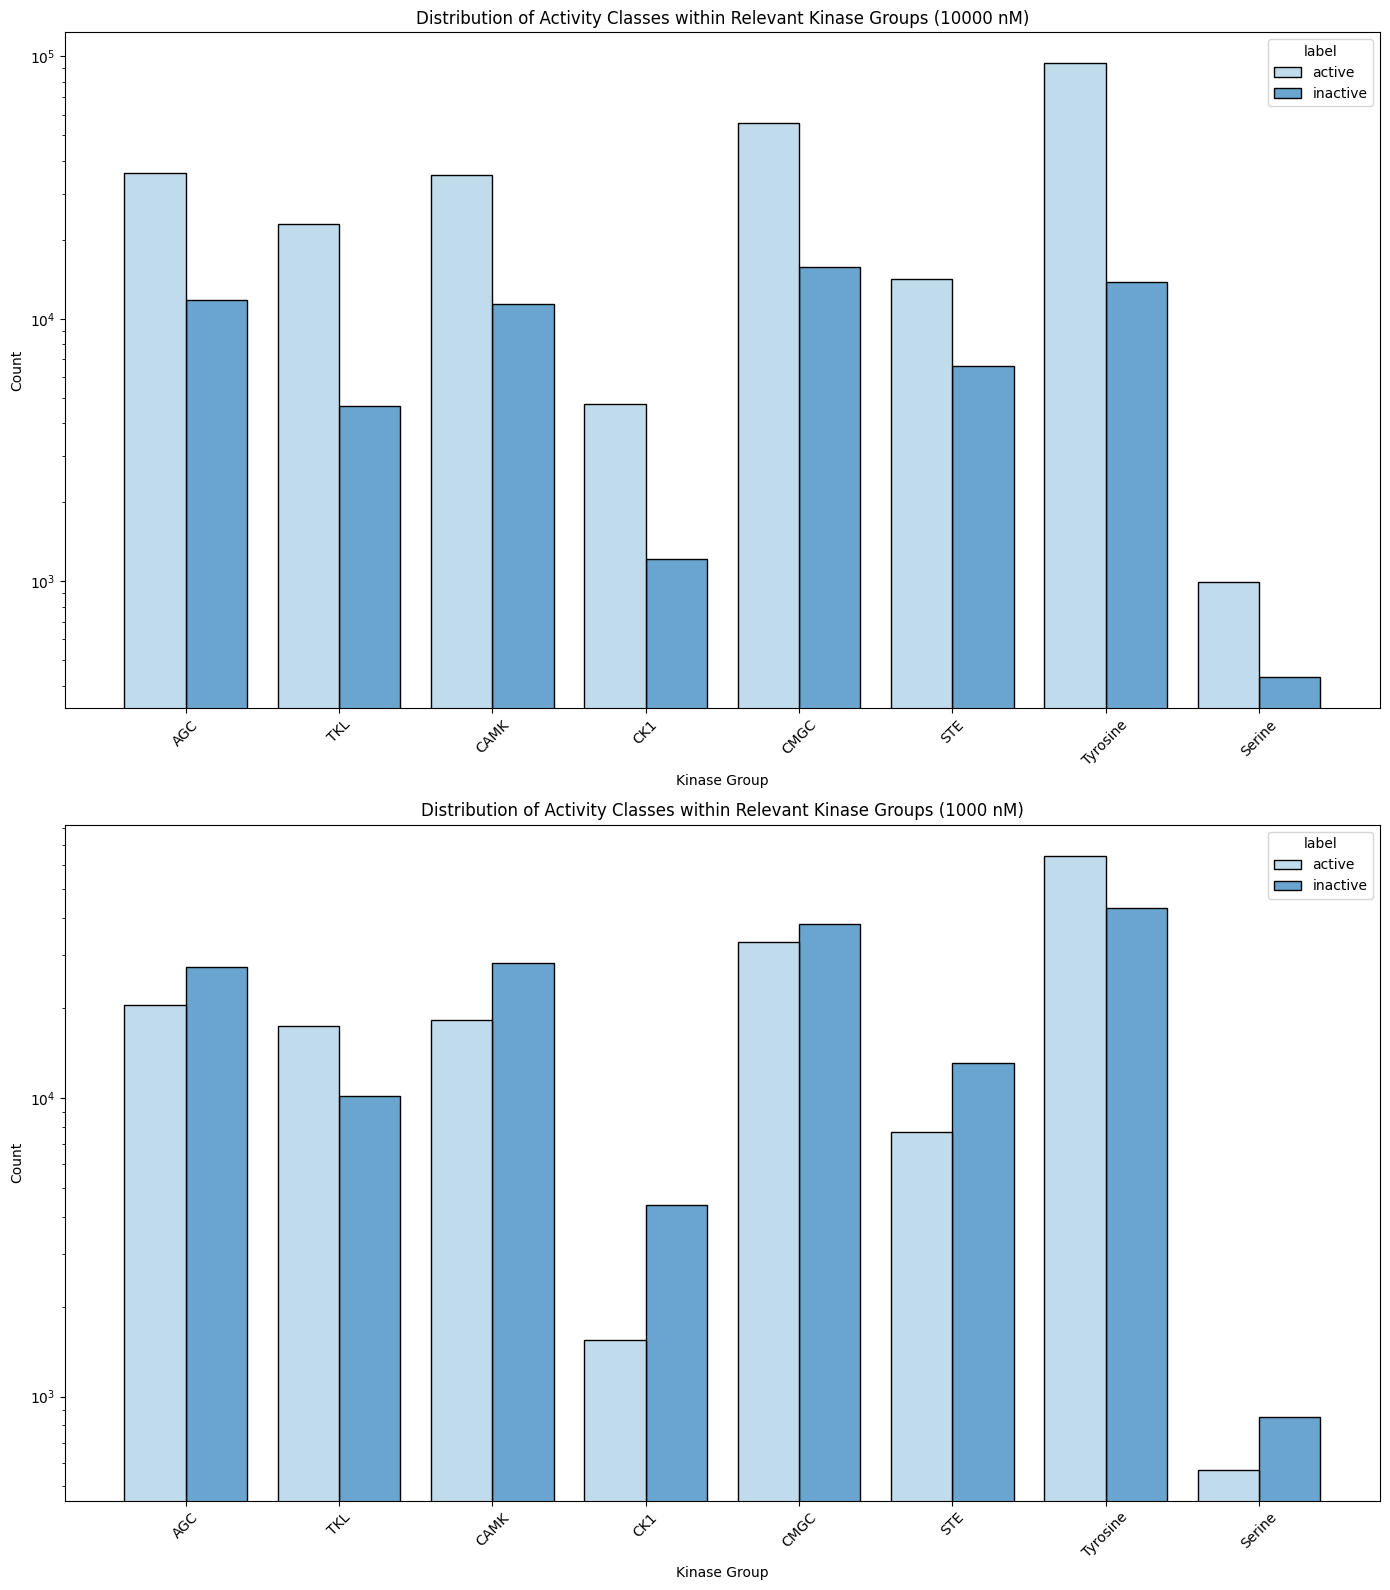

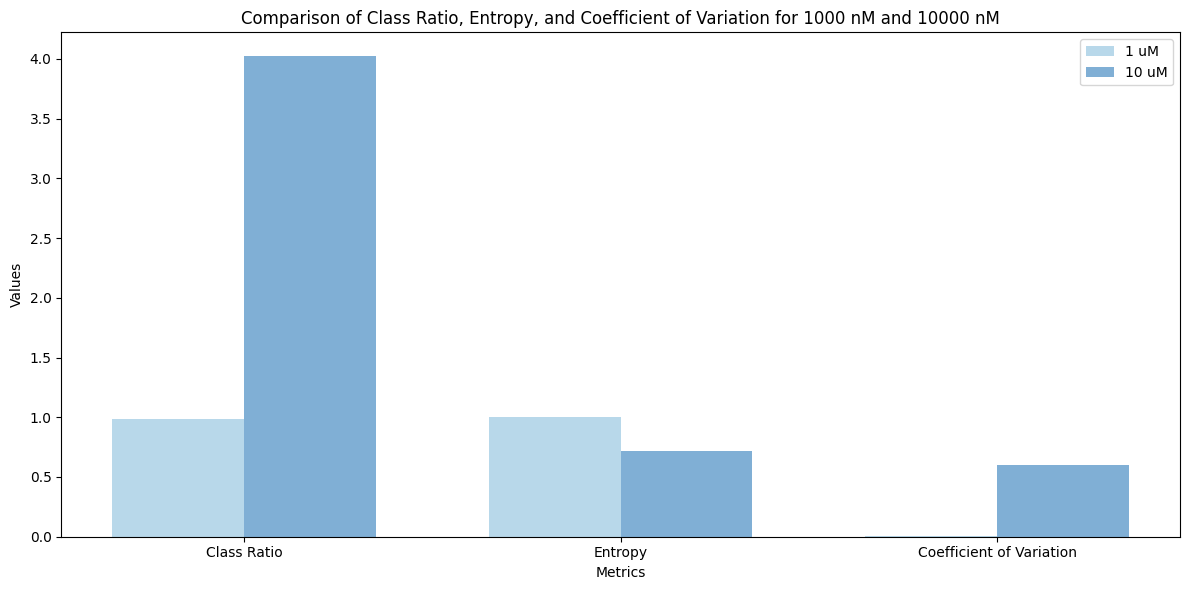

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy

class CheckBalance:
    def __init__(self, filepath, activity_threshold):
        self.filepath = filepath
        self.activity_threshold = activity_threshold
        self.data = self.load_data()

    def load_data(self):
        # Load only the necessary columns
        columns = ['chembl_id', 'molregno', 'target_kinase', 'canonical_smiles',
                   'standard_value', 'standard_type', 'kinase_group']
        return pd.read_csv(self.filepath, sep='\t', usecols=columns, low_memory=False)

    def prepare_labels(self):
        # Ensure the standard_value column is numeric
        self.data['standard_value'] = pd.to_numeric(self.data['standard_value'], errors='coerce')
        # Prepare labels based on activity thresholds
        self.data['label'] = self.data['standard_value'].apply(lambda x: 'active' if pd.notna(x) and x < self.activity_threshold else 'inactive')

    def filter_relevant_groups(self):
        # Define the relevant kinase groups
        relevant_kinase_groups = [
            'AGC', 'Other', 'TKL', 'CAMK', 'CK1', 'CMGC', 'STE', 'Tyrosine',
            'Transferse', 'Serine', 'Nuclear', 'Lyase'
        ]
        self.data = self.data[self.data['kinase_group'].isin(relevant_kinase_groups)]

    def analyze_class_balance(self):
        # Ensure labels are prepared
        if 'label' not in self.data.columns:
            self.prepare_labels()

        # Filter the kinase groups to exclude irrelevant ones
        self.filter_relevant_groups()

        # Analyze class balance within each kinase group
        class_counts = self.data.groupby(['kinase_group', 'label']).size().unstack(fill_value=0)

        return self.data

    def analyze_class_metrics(self):
        # Ensure labels are prepared
        if 'label' not in self.data.columns:
            self.prepare_labels()

        # Calculate class counts and ratios
        class_counts = self.data['label'].value_counts()
        class_ratio = class_counts['active'] / class_counts['inactive'] if 'active' in class_counts and 'inactive' in class_counts else float('inf')

        # Calculate entropy
        probability_distribution = class_counts / class_counts.sum()
        data_entropy = entropy(probability_distribution, base=2)

        # Calculate the coefficient of variation
        coeff_variation = np.std(class_counts) / np.mean(class_counts)

        results = pd.DataFrame({
            "Metric": ["Class Ratio", "Entropy of Distribution", "Coefficient of Variation"],
            "Value": [class_ratio, data_entropy, coeff_variation]
        })
        results.to_csv(f'data_balance_statistics_{self.activity_threshold}.tsv', sep='\t', index=False)

        return class_ratio, data_entropy, coeff_variation

    def save_output(self):
        if 'label' not in self.data.columns:
            self.prepare_labels()

        self.filter_relevant_groups()
        self.data.to_csv(f'filtered_dataset_{self.activity_threshold}.tsv', sep="\t", index=False)

def run_analysis(activity_threshold, filepath):
    checker = CheckBalance(filepath, activity_threshold)
    checker.save_output()  # Save the output with specific rows removed
    class_ratio, data_entropy, coeff_variation = checker.analyze_class_metrics()  # Calculate and save class metrics
    data = checker.analyze_class_balance()  # Analyze and return data for balance comparison
    return data, class_ratio, data_entropy, coeff_variation

def plot_combined_results(data_1000, data_10000, metrics_1000, metrics_10000):
    # Combine datasets
    data_1000['threshold'] = '1 uM'
    data_10000['threshold'] = '10 uM'
    combined_data = pd.concat([data_1000, data_10000])

    # Plot overall class balance
    plt.figure(figsize=(12, 6))
    sns.countplot(data=combined_data, x='label', hue='threshold', palette='Blues', dodge=True)
    plt.title('Overall Class Balance')
    plt.xlabel('Activity Class')
    plt.ylabel('Number of Compounds')
    # plt.yscale('log')
    plt.legend(title='Threshold')
    plt.savefig('class_balance_overall_combined.png')
    plt.show()

    # Plot box plot for standard value by activity class
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=combined_data, x='label', y='standard_value', hue='threshold', palette='Blues')
    plt.title('Box Plot of Standard Value by Activity Class')
    plt.xlabel('Activity Class')
    plt.ylabel('Standard Value')
    plt.yscale('log')
    plt.savefig('boxplot_standard_value_by_label_combined.png')
    plt.show()

    # Plot distribution of activity classes within relevant kinase groups for each threshold separately
    fig, axes = plt.subplots(2, 1, figsize=(14, 16))

    sns.histplot(data=data_10000, x='kinase_group', hue='label', multiple="dodge", shrink=.8, palette='Blues', hue_order=['active', 'inactive'], ax=axes[0])
    axes[0].set_title('Distribution of Activity Classes within Relevant Kinase Groups (10000 nM)')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_xlabel('Kinase Group')
    axes[0].set_ylabel('Count')
    axes[0].set_yscale('log')
    # axes[0].legend(title='Activity Class')

    sns.histplot(data=data_1000, x='kinase_group', hue='label', multiple="dodge", shrink=.8, palette='Blues', hue_order=['active', 'inactive'], ax=axes[1])
    axes[1].set_title('Distribution of Activity Classes within Relevant Kinase Groups (1000 nM)')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].set_xlabel('Kinase Group')
    axes[1].set_ylabel('Count')
    axes[1].set_yscale('log')
    # axes[1].legend(title='Activity Class')

    plt.tight_layout()
    plt.savefig('distribution_activity_classes_kinase_groups_combined.png')
    plt.show()

    # Plot Class Ratio, Entropy, and Coefficient of Variation
    labels = ['Class Ratio', 'Entropy', 'Coefficient of Variation']
    values_1000 = list(metrics_1000)
    values_10000 = list(metrics_10000)

    x = range(len(labels))
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35

    blues_palette = sns.color_palette('Blues', 6)
    light_blue = blues_palette[2]
    dark_blue = blues_palette[4]

    bar_1000 = ax.bar(x, values_1000, width=bar_width, label='1 uM', color=light_blue, alpha=0.6)
    bar_10000 = ax.bar([p + bar_width for p in x], values_10000, width=bar_width, label='10 uM', color=dark_blue, alpha=0.6)

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Comparison of Class Ratio, Entropy, and Coefficient of Variation for 1000 nM and 10000 nM')
    ax.set_xticks([p + bar_width / 2 for p in x])
    ax.set_xticklabels(labels)
    ax.legend()

    plt.tight_layout()
    plt.savefig('class_metrics_comparison.png')
    plt.show()

def main():
    filepath = '/content/filtered_dataset.tsv'

    data_1000, class_ratio_1000, entropy_1000, variation_1000 = run_analysis(1000, filepath)
    data_10000, class_ratio_10000, entropy_10000, variation_10000 = run_analysis(10000, filepath)  # Set activity threshold for nM (e.g., 10µM expressed as 10000 nM)

    metrics_1000 = (class_ratio_1000, entropy_1000, variation_1000)
    metrics_10000 = (class_ratio_10000, entropy_10000, variation_10000)

    plot_combined_results(data_1000, data_10000, metrics_1000, metrics_10000)

if __name__ == "__main__":
    main()



Model: DeepChem_ChemBERTa-10M-MLM
Best Parameters: {'learning_rate': 1.9000194276448415e-05, 'epochs': 6}
Final Test Loss: 0.683770796726266
Final Test Class Avg Accuracy: 0.8837063447447912
Final Test Precision: 0.8942934735831689
Final Test Recall: 0.5153208175729603
Final Test F1 Score: 0.6315528731113788


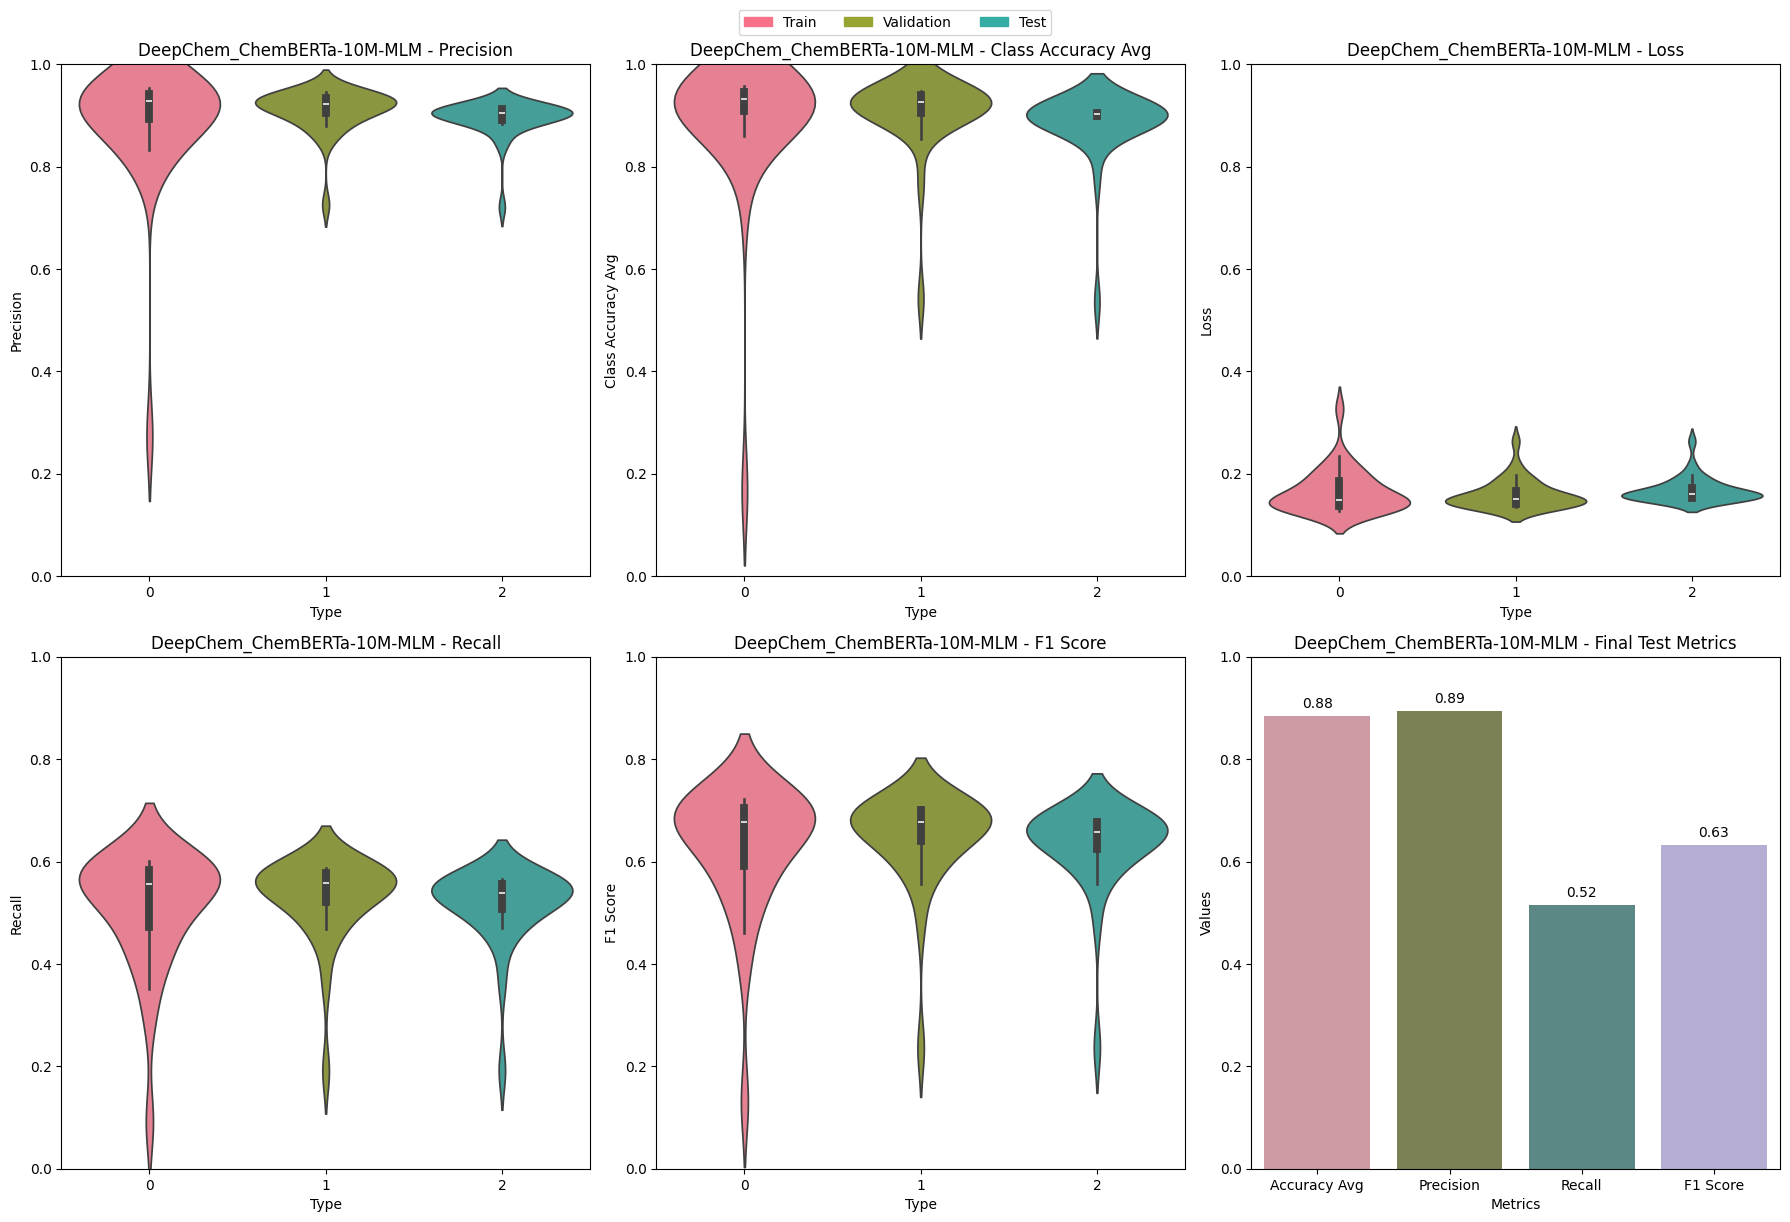


Model: DeepChem_ChemBERTa-10M-MTR
Best Parameters: {'learning_rate': 1.79312375392709e-05, 'epochs': 5}
Final Test Loss: 0.6660015896224203
Final Test Class Avg Accuracy: 0.8803240195226284
Final Test Precision: 0.8830124462189356
Final Test Recall: 0.48186764756914313
Final Test F1 Score: 0.599949455098206


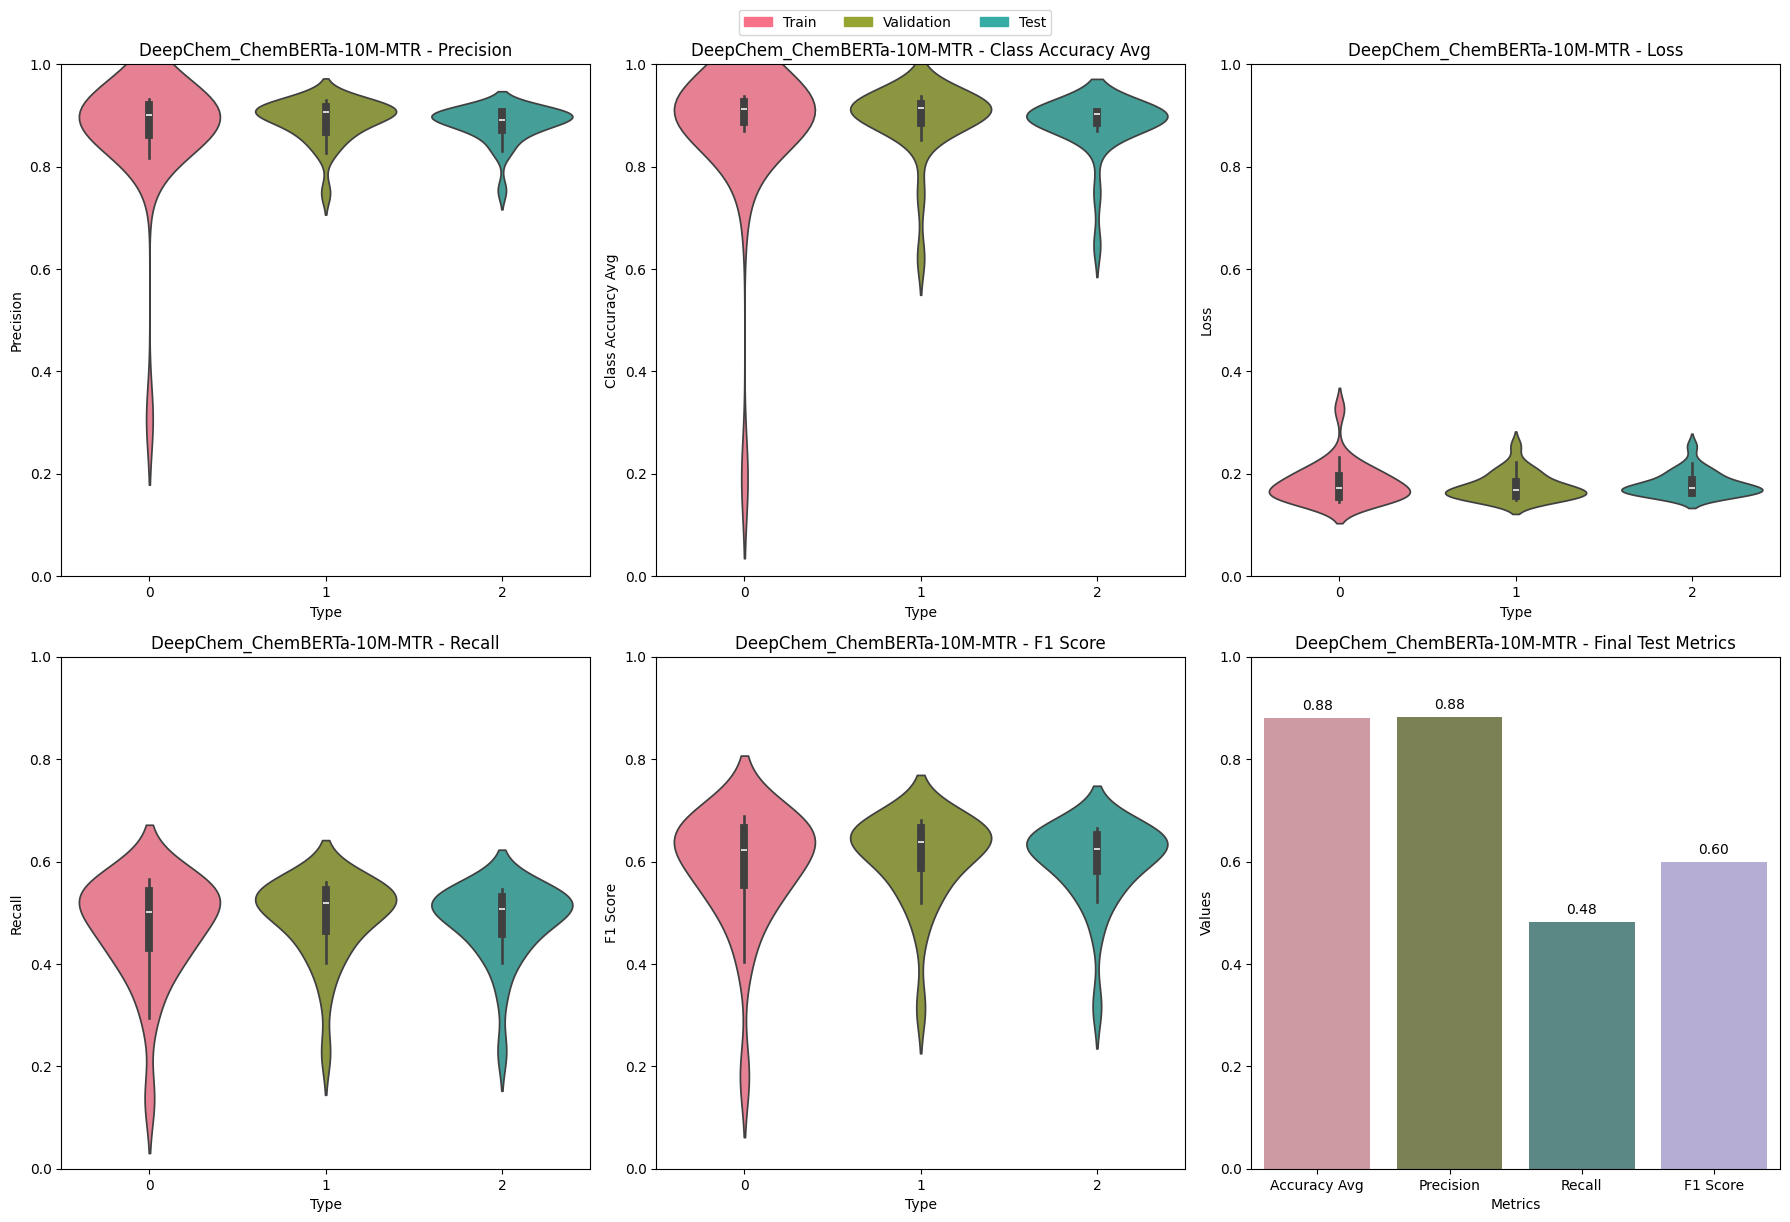


Consolidated report saved as 'consolidated_report.json'


In [6]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Patch
import pandas as pd

class VisualizePreTrainedLLMResults:
    def __init__(self, json_files):
        self.json_files = json_files

    def load_metrics(self, file_path):
        with open(file_path, 'r') as f:
            return json.load(f)

    def analyze_metrics(self, metrics, model_name):
        epochs = [m['epoch'] for m in metrics['epoch_metrics']]
        train_losses = [m['train_loss'] for m in metrics['epoch_metrics']]
        val_losses = [m['val_loss'] for m in metrics['epoch_metrics']]
        test_losses = [m['test_loss'] for m in metrics['epoch_metrics']]
        train_accuracies = [m['train_accuracy'] for m in metrics['epoch_metrics']]
        val_accuracies = [m['val_accuracy'] for m in metrics['epoch_metrics']]
        test_accuracies = [m['test_accuracy'] for m in metrics['epoch_metrics']]
        train_precisions = [m['train_precision'] for m in metrics['epoch_metrics']]
        val_precisions = [m['val_precision'] for m in metrics['epoch_metrics']]
        test_precisions = [m['test_precision'] for m in metrics['epoch_metrics']]
        train_recalls = [m['train_recall'] for m in metrics['epoch_metrics']]
        val_recalls = [m['val_recall'] for m in metrics['epoch_metrics']]
        test_recalls = [m['test_recall'] for m in metrics['epoch_metrics']]
        train_f1s = [m['train_f1'] for m in metrics['epoch_metrics']]
        val_f1s = [m['val_f1'] for m in metrics['epoch_metrics']]
        test_f1s = [m['test_f1'] for m in metrics['epoch_metrics']]
        train_class_avg_accuracies = [m['train_class_avg_accuracy'] for m in metrics['epoch_metrics']]
        val_class_avg_accuracies = [m['val_class_avg_accuracy'] for m in metrics['epoch_metrics']]
        test_class_avg_accuracies = [m['test_class_avg_accuracy'] for m in metrics['epoch_metrics']]
        roc_aucs = [m['roc_auc'] for m in metrics['epoch_metrics']]
        pr_aucs = [m['pr_auc'] for m in metrics['epoch_metrics']]

        model_display_name = model_name.split('/')[-1]

        # Calculate the average final metrics
        final_test_class_avg_accuracy = np.mean(test_class_avg_accuracies)
        final_test_precision = np.mean(test_precisions)
        final_test_recall = np.mean(test_recalls)
        final_test_f1 = np.mean(test_f1s)
        final_test_roc_auc = np.mean(roc_aucs)
        final_test_pr_auc = np.mean(pr_aucs)

        print(f"\nModel: {model_display_name}")
        print(f"Best Parameters: {metrics['best_params']}")
        print(f"Final Test Loss: {metrics['test_loss']}")
        print(f"Final Test Class Avg Accuracy: {final_test_class_avg_accuracy}")
        print(f"Final Test Precision: {final_test_precision}")
        print(f"Final Test Recall: {final_test_recall}")
        print(f"Final Test F1 Score: {final_test_f1}")

        plt.figure(figsize=(18, 12))

        colors = sns.color_palette("husl", 4)  # Four colors for train, validation, test, and ROC/PR AUC
        final_colors = sns.color_palette("husl", 4, desat=0.5)  # Distinct colors for final metrics

        plt.subplot(2, 3, 1)
        sns.violinplot(data=[train_precisions, val_precisions, test_precisions], palette=colors[:3])
        plt.xlabel('Type')
        plt.ylabel('Precision')
        plt.title(f'{model_display_name} - Precision')
        plt.ylim(0, 1)

        plt.subplot(2, 3, 2)
        sns.violinplot(data=[train_class_avg_accuracies, val_class_avg_accuracies, test_class_avg_accuracies], palette=colors[:3])
        plt.xlabel('Type')
        plt.ylabel('Class Accuracy Avg')
        plt.title(f'{model_display_name} - Class Accuracy Avg')
        plt.ylim(0, 1)

        plt.subplot(2, 3, 3)
        sns.violinplot(data=[train_losses, val_losses, test_losses], palette=colors[:3])
        plt.xlabel('Type')
        plt.ylabel('Loss')
        plt.title(f'{model_display_name} - Loss')
        plt.ylim(0, 1)

        plt.subplot(2, 3, 4)
        sns.violinplot(data=[train_recalls, val_recalls, test_recalls], palette=colors[:3])
        plt.xlabel('Type')
        plt.ylabel('Recall')
        plt.title(f'{model_display_name} - Recall')
        plt.ylim(0, 1)

        plt.subplot(2, 3, 5)
        sns.violinplot(data=[train_f1s, val_f1s, test_f1s], palette=colors[:3])
        plt.xlabel('Type')
        plt.ylabel('F1 Score')
        plt.title(f'{model_display_name} - F1 Score')
        plt.ylim(0, 1)

        plt.subplot(2, 3, 6)
        metrics_names = ['Accuracy Avg', 'Precision', 'Recall', 'F1 Score']
        final_metrics = [final_test_class_avg_accuracy, final_test_precision, final_test_recall, final_test_f1]
        final_metrics_df = pd.DataFrame({'Metrics': metrics_names, 'Values': final_metrics, 'Hue': metrics_names})
        sns.barplot(x='Metrics', y='Values', hue='Hue', data=final_metrics_df, palette=final_colors, dodge=False, legend=False)
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        plt.title(f'{model_display_name} - Final Test Metrics')
        plt.ylim(0, 1)
        for i, v in enumerate(final_metrics):
            plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

        # Overall legend
        legend_handles = [Patch(color=colors[0], label='Train'), Patch(color=colors[1], label='Validation'), Patch(color=colors[2], label='Test')]
        plt.figlegend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3)

        plt.tight_layout()
        plt.savefig(f'{model_display_name}_metrics.png')
        plt.show()

    def run_analysis(self):
        metrics_data = []

        for file in self.json_files:
            file_path = os.path.join('./', file)
            if os.path.exists(file_path):
                metrics = self.load_metrics(file_path)
                model_name = file.split('metrics_')[1].split('.json')[0]  # Get the full model name
                self.analyze_metrics(metrics, model_name)
                metrics_data.append((model_name, metrics))
            else:
                print(f"File {file_path} does not exist.")

        # Generate a consolidated report
        report = {
            model: {
                "best_params": metrics["best_params"],
                "final_metrics": {
                    "test_loss": metrics["test_loss"],
                    "class_avg_accuracy": np.mean([m['test_class_avg_accuracy'] for m in metrics['epoch_metrics']]),
                    "precision": np.mean([m['test_precision'] for m in metrics['epoch_metrics']]),
                    "recall": np.mean([m['test_recall'] for m in metrics['epoch_metrics']]),
                    "f1": np.mean([m['test_f1'] for m in metrics['epoch_metrics']]),
                    "roc_auc": np.mean([m['roc_auc'] for m in metrics['epoch_metrics']]),
                    "pr_auc": np.mean([m['pr_auc'] for m in metrics['epoch_metrics']])
                }
            }
            for model, metrics in metrics_data
        }

        with open('consolidated_report.json', 'w') as f:
            json.dump(report, f, indent=4)

        print("\nConsolidated report saved as 'consolidated_report.json'")


if __name__ == "__main__":
    json_files = ['/content/metrics_DeepChem_ChemBERTa-10M-MLM.json', '/content/metrics_DeepChem_ChemBERTa-10M-MTR.json']
    visualizer = VisualizePreTrainedLLMResults(json_files)
    visualizer.run_analysis()


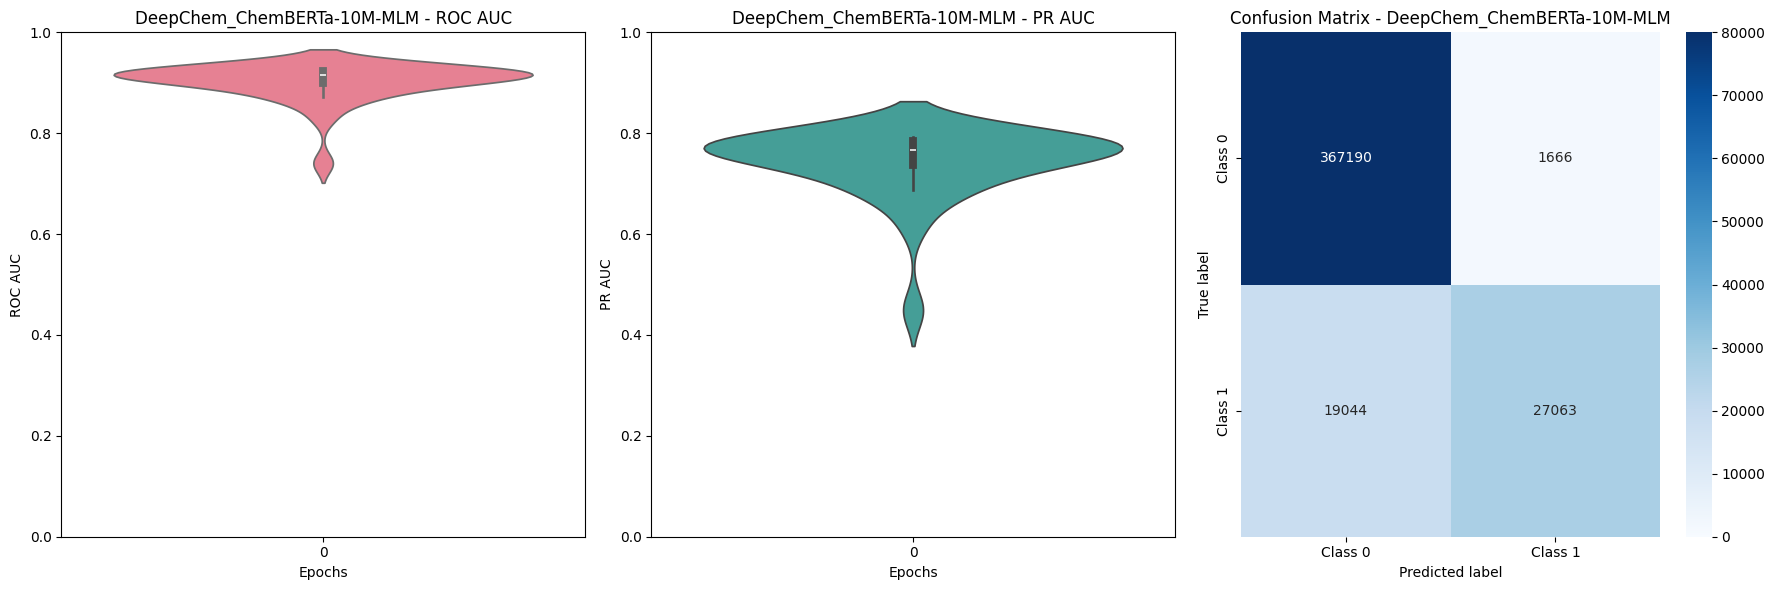

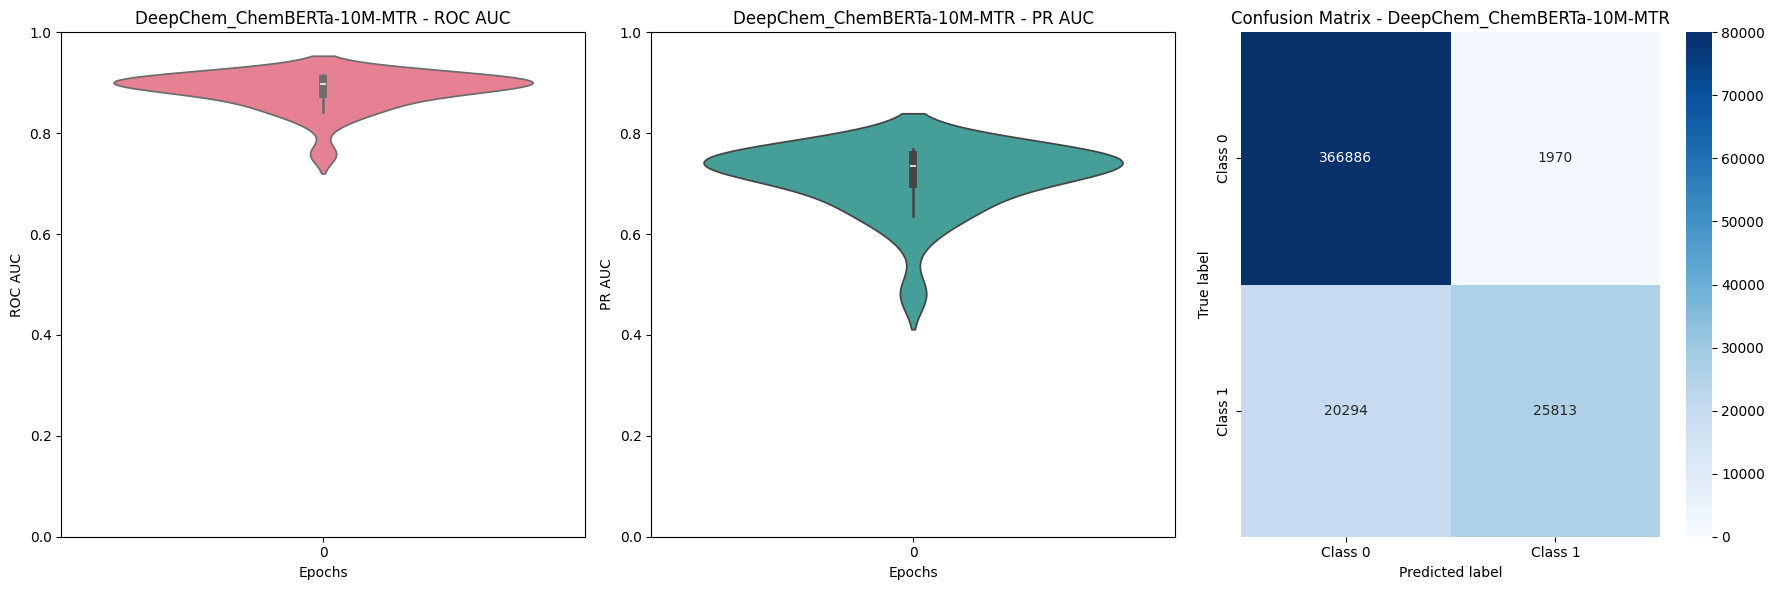

In [22]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

class VisualizeROCAndPRAUCViolin:
    def __init__(self, json_files):
        self.json_files = json_files

    def load_metrics(self, file_path):
        with open(file_path, 'r') as f:
            return json.load(f)

    def plot_violin(self, data, title, ylabel, palette):
        sns.violinplot(data=[data], palette=[palette])
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.ylim(0, 1)

    def plot_confusion_matrix(self, cm, classes, model_name):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, vmin=0, vmax=80000)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.title(f'Confusion Matrix - {model_name}')

    def analyze_metrics(self, metrics, model_name):
        roc_aucs = [m['roc_auc'] for m in metrics['epoch_metrics']]
        pr_aucs = [m['pr_auc'] for m in metrics['epoch_metrics']]
        model_display_name = model_name.split('/')[-1]

        # Select the best epoch based on validation F1 score
        best_epoch_metric = max(metrics['epoch_metrics'], key=lambda x: x['val_f1'])
        cm = np.sum(np.array(best_epoch_metric['conf_matrix']), axis=0)
        classes = [f'Class {i}' for i in range(cm.shape[0])]

        plt.figure(figsize=(18, 6))

        colors = sns.color_palette("husl", 2)  # Two colors for ROC AUC and PR AUC

        # ROC AUC plot as violin plot with a distinct color
        plt.subplot(1, 3, 1)
        self.plot_violin(roc_aucs, f'{model_display_name} - ROC AUC', 'ROC AUC', colors[0])

        # PR AUC plot as violin plot with a distinct color
        plt.subplot(1, 3, 2)
        self.plot_violin(pr_aucs, f'{model_display_name} - PR AUC', 'PR AUC', colors[1])

        # Confusion Matrix
        plt.subplot(1, 3, 3)
        self.plot_confusion_matrix(cm, classes, model_display_name)

        plt.tight_layout()
        plt.savefig(f'{model_display_name}_roc_pr_auc_conf_matrix.png')
        plt.show()

    def run_analysis(self):
        for file in self.json_files:
            file_path = os.path.join('./', file)
            if os.path.exists(file_path):
                metrics = self.load_metrics(file_path)
                model_name = file.split('metrics_')[1].split('.json')[0]
                self.analyze_metrics(metrics, model_name)
            else:
                print(f"File {file_path} does not exist.")

if __name__ == "__main__":
    json_files = ['/content/metrics_DeepChem_ChemBERTa-10M-MLM.json', '/content/metrics_DeepChem_ChemBERTa-10M-MTR.json']
    visualizer = VisualizeROCAndPRAUCViolin(json_files)
    visualizer.run_analysis()
